In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.animation
import pandas as pd
from IPython.display import HTML
import os
from collections import Counter
from mpire import WorkerPool

sns.set_style("darkgrid")
plt.rcParams["animation.html"] = "html5"

In [3]:
class Graph(nx.Graph):
    def random_graph(self, n, p):
        eges_nr = np.sum([i for i in range(n)])
        edges = np.array([[i, j] for i in range(n-1) for j in range(i+1,n) if np.random.uniform() < p ])
        # all_edges = np.array([[i, j] for i in range(n-1) for j in range(i+1,n)])
        # taked_edes = np.random.uniform(size=eges_nr)<p
        # edges_to_add = all_edges[taked_edes]
        self.add_nodes_from(range(n))
        # self.add_edges_from(edges_to_add)
        self.add_edges_from(edges)
        return self
    
    def Watts_Strogatz_model(self, n , k, p):
        """Returns a Watts–Strogatz small-world graph.

        Parameters
        ----------
        n : int
            The number of nodes
        k : int
            Each node is joined with its `k` nearest neighbors in a ring
            topology.
        p : float
            The probability of rewiring each edge
        """
        if k>n:
            raise ValueError(f"The parameter 'k' = {k} is greater than parametr 'n' = {n}")
        elif k == n:
            return nx.complete_graph(n)
        # g = nx.Graph()
        self.add_nodes_from(range(n))
        
        nodes = self.nodes
        for i in range(n):
            for j in range(1, k // 2 + 1):
                self.add_edge(i, (i+j)%n)
                
        for node in nodes:
            for neighbour in range(1, k // 2 + 1):
                if np.random.uniform() < p:
                    random_note = np.random.choice(nodes)
                    while node == random_note or self.has_edge(node, random_note):
                        random_note = np.random.choice(nodes)
                    else:
                        self.remove_edge(node, (node + neighbour)%n)
                        self.add_edge(node, random_note)
                else:
                    pass
        return self

    def barabasi_albert_model(self, m0, n, iterations, inicial_praph = None):
        if inicial_praph:
            g = inicial_praph
        else:
            g = nx.complete_graph(m0)
        degrees = {note:degre for note,degre in g.degree() }
        for node in range(m0, m0 + iterations):
            values = np.array(list(degrees.values()))
            nodes_to_conect = np.random.choice(list(degrees.keys()), size = n, replace=False, p = values/sum(values))
            degrees[node] = n
            for node_to_conect in nodes_to_conect:
                degrees[node_to_conect] += 1
            g.add_edges_from([[node, i] for i in nodes_to_conect ])
        return g
        
    def lattice_2d(m, n):
        g = nx.grid_2d_graph(m, n)
        return g

In [4]:
def flips(array, spinson):
    for i in spinson:
        array[i] *= -1

def set_spin(array, spinson, spins):
    for i, spin in zip(spinson, spins):
        array[i] = spin
        
def q_voter_model(graph, p, q, epsilon, MC_steps, save_array_name = None, save_dir = "save_array", set_attributes = True, save = True) :
    if set_attributes:
        nx.set_node_attributes(graph, 1, "state")
    nodes = graph.nodes()
    N = len(nodes)
    if not save_array_name:
        save_array_name = f"graph_{str(graph)} p_{p} q_{q} epsilon_{epsilon} MC_steps_{MC_steps}"
    save_array = np.zeros((MC_steps, N))

    attributes_dict = nx.get_node_attributes(graph, "state")
    attributes_list = np.array(list(attributes_dict.values()))
    neighbors_list = tuple(tuple(graph.neighbors(n)) for n in nodes)
    for MC_step in range(MC_steps):
        save_array[MC_step] = attributes_list
        random_spinson = np.random.randint(0, N, N)
        #independence case
        independence = np.random.uniform(size=N) < p
        independence_spinson = random_spinson[independence]
        if_flip = np.random.uniform(size=len(independence_spinson)) < 0.5
        # attributes_list[independence_spinson]  *= -1
        flips(attributes_list, independence_spinson[if_flip])

        #other case
        not_independence_spinson = random_spinson[~independence]
        if np.any(not_independence_spinson):
            random_neighbors = [random.choices(neighbors_list[n], k = q) for n in not_independence_spinson]
            random_neighbors_state = attributes_list[random_neighbors]
            same_state = np.abs(np.sum(random_neighbors_state, 1)) == q
            # attributes_list[not_independence_spinson[same_state]] *= -1
            # flips(attributes_list, not_independence_spinson[same_state])
            set_spin(attributes_list, not_independence_spinson[same_state], random_neighbors_state[same_state][:,0])
            #otherwise
            not_unanimous = not_independence_spinson[~same_state]
            flip_not_unanimous = not_unanimous[np.random.uniform(size=len(not_unanimous)) < epsilon]
            # attributes_list[flip_not_unanimous] *= -1
            flips(attributes_list, flip_not_unanimous)
        
    
    if save:
        try:
            os.makedirs(save_dir)
        except:
            pass
        # print(f"{save_dir}/{save_array_name}")
        np.save(f"{save_dir}{save_array_name}", np.mean(save_array,1))
    return save_array
# graph = Graph().Watts_Strogatz_model(6, 4, 0)
# q_voter_model(graph, 0.5, q, 1, 10, save_array_name, save_dir = path, save=False)



In [5]:
def create_df_from_save_dir(graph_type, epsilons, ps, n, qs, MC_steps):
    df = pd.DataFrame()
    for epsilon in epsilons:
        for q in qs:
            for p in ps:
                np_df = np.zeros((100, MC_steps))
                for i in range(n):
                    try:
                        graph_name = graph_type + f"_{i}"
                        path = f"save_array/{graph_type}/p_{p}/q_{q}/epsilon_{epsilon}"
                        save_array_name = f"graph_{graph_name} p_{p} q_{q} epsilon_{epsilon} MC_steps_{MC_steps}"
                        with open(f"{path}/{save_array_name}.npy", 'rb') as f:
                            array = np.load(f)
                            np_df[i] = array
                        _df = pd.DataFrame(np_df)
                        _df["p"] = p
                        _df["q"] = q
                        _df["epsilon"] = epsilon
                    except:
                        pass
                df = pd.concat([df, _df])
    return df

In [6]:
def simulacion(graph, graph_type, epsilons, ps, n, q, MC_steps, progress_bar = False, n_jobs = 4):
    with WorkerPool(n_jobs=n_jobs) as pool:
        for epsilon in epsilons:
            arg_list = []
            for p in ps:
                for i in range(n):
                    graph_name = graph_type + f"_{i}"
                    path = f"save_array/{graph_type}/p_{p}/q_{q}/epsilon_{epsilon}/"
                    save_array_name = f"graph_{graph_name} p_{p} q_{q} epsilon_{epsilon} MC_steps_{MC_steps}"
                    graph, p, q, epsilon, MC_steps, None, "save_array",  True, False
                    arg_list.append([graph, p, q, epsilon, MC_steps, save_array_name, path,  True, True])
            pool.map(q_voter_model,arg_list, progress_bar = progress_bar)

# NN

In [9]:
NN_graph = Graph().Watts_Strogatz_model(100, 4, 0)
qs = [3, 4]
MC_steps = 1000
epsilon = 0.5
graph_type = "NN"
ps = np.arange(0, 0.52, 0.02).round(3)
epsilons = [0, 0.05, 0.1, 0.2]
n = 100

In [10]:
for q in qs:
    simulacion(NN_graph, graph_type, epsilons, ps, n, q, MC_steps, True)

100%|██████████| 2600/2600 [04:30<00:00,  9.90it/s]


In [11]:
df = create_df_from_save_dir(graph_type, epsilons, ps, n, qs, MC_steps)
melt_df = df.melt(["p", "q", "epsilon"], var_name="t", value_name="mean")

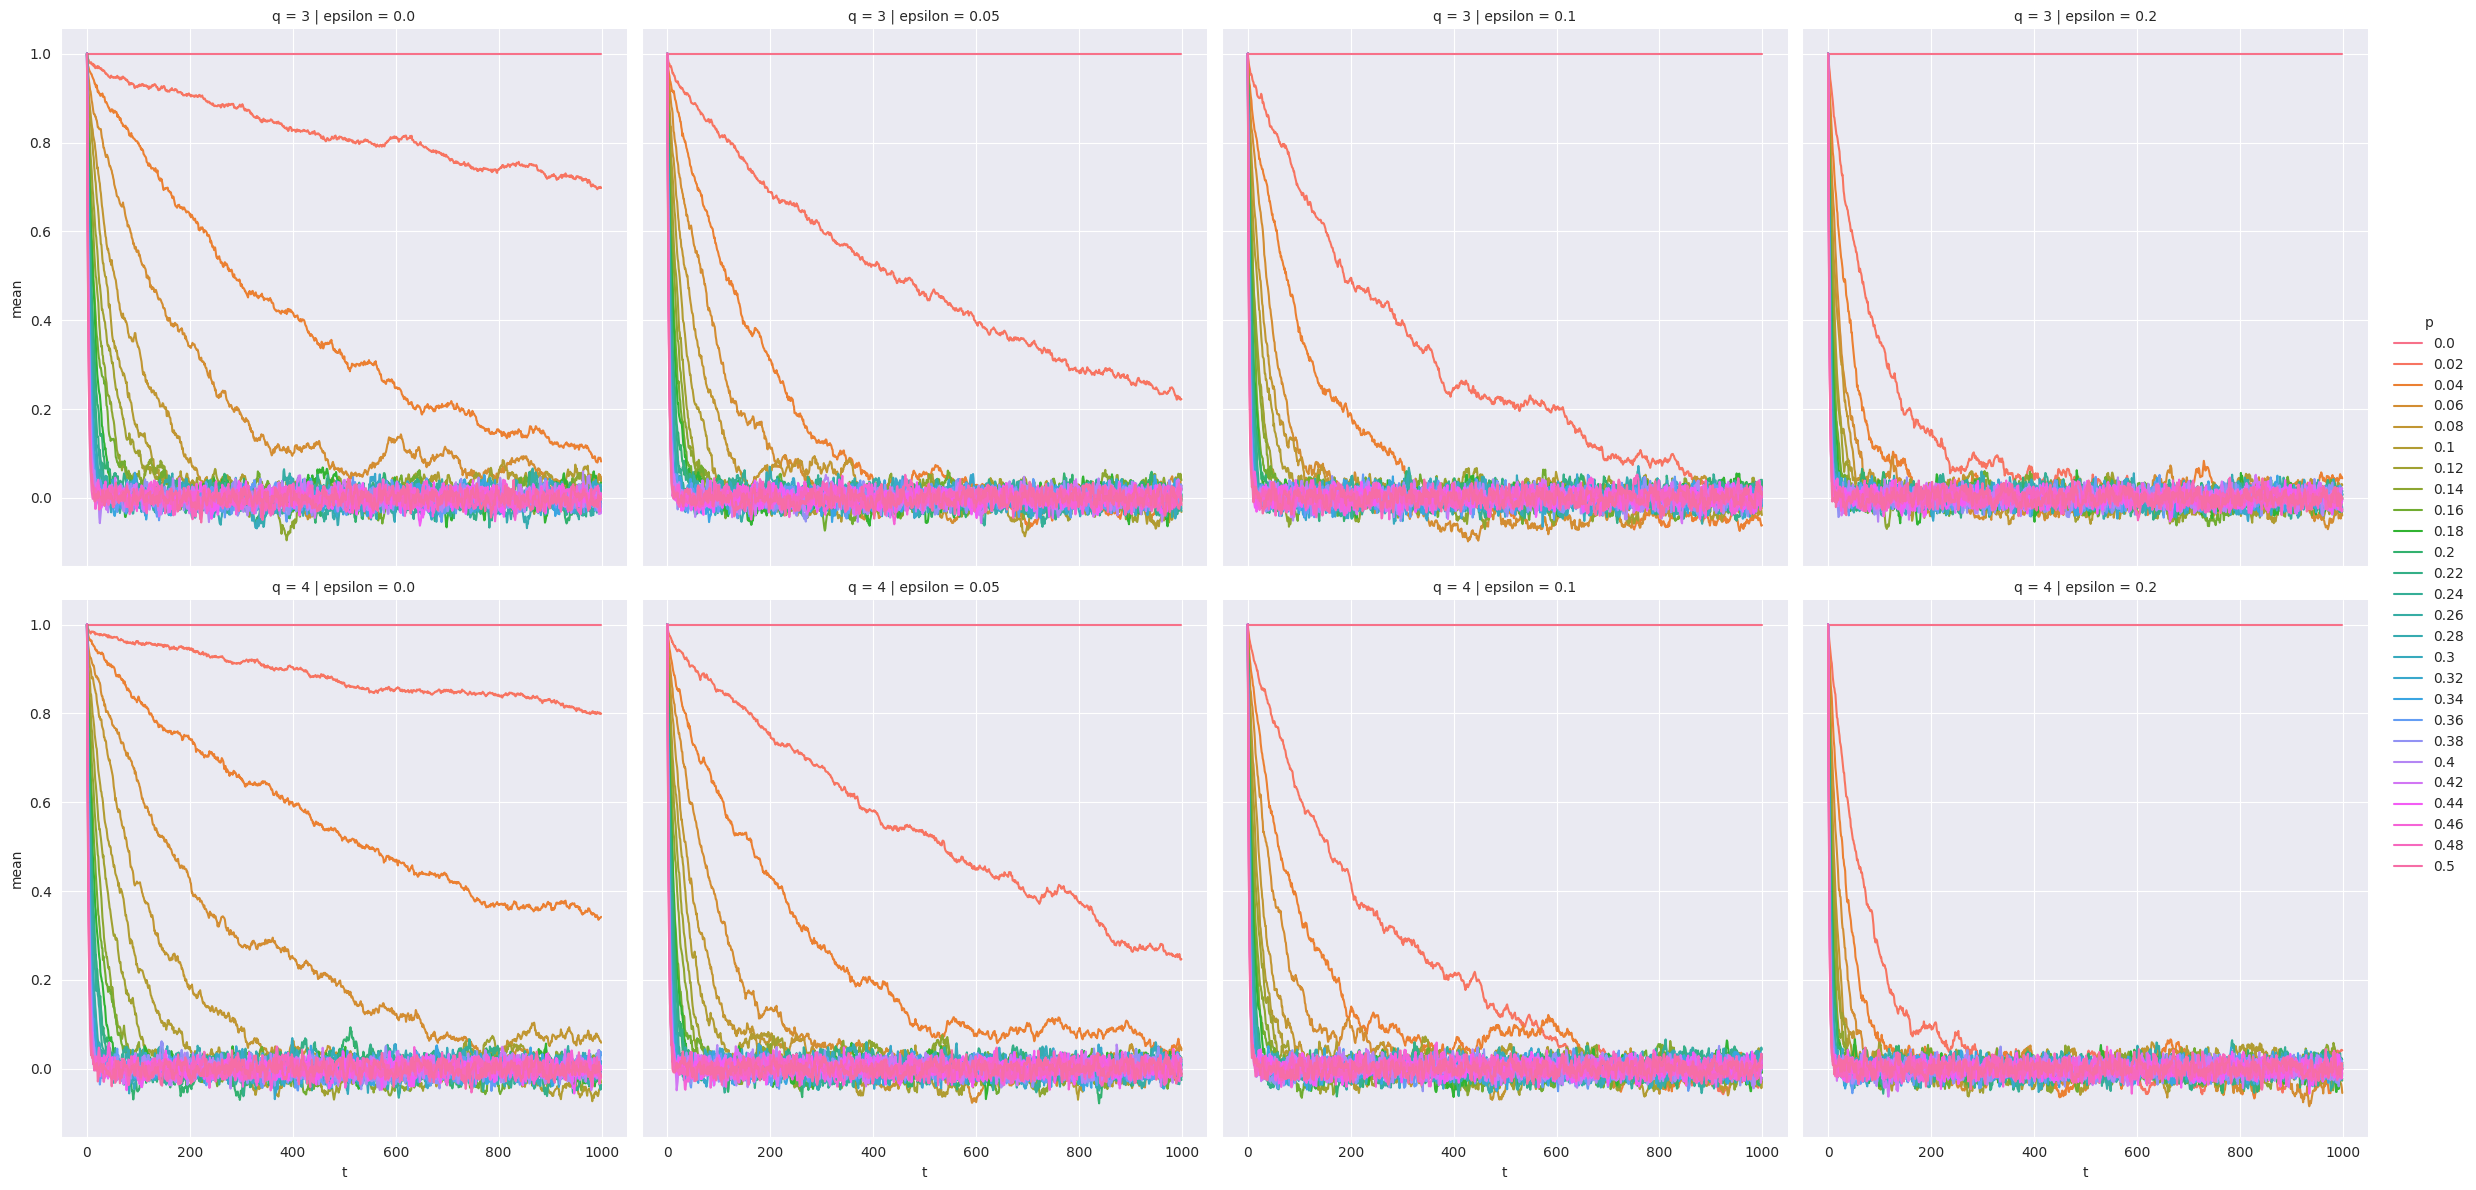

In [12]:
g = sns.FacetGrid(melt_df, col="epsilon", row="q", hue="p",  height=6)
g.map(sns.lineplot, "t", "mean", errorbar = None)
g.add_legend()

# BA(100, 4)

In [6]:
m0 =4
n = 4
iterations  = 96
BA_100_4 = Graph().barabasi_albert_model(m0, n, iterations = iterations)

qs = [3, 4]
MC_steps = 1000
epsilon = 0.5
graph_type = "BA_100_4"
ps = np.arange(0, 0.52, 0.02).round(3)
epsilons = [0, 0.05, 0.1, 0.2]
n = 100

In [7]:
for q in qs:
    simulacion(BA_100_4, graph_type, epsilons, ps, n, q, MC_steps, True)

100%|██████████| 2600/2600 [04:22<00:00,  9.98it/s]


In [9]:
df_BA_100_4 = create_df_from_save_dir(graph_type, epsilons, ps, n, qs, MC_steps)
melt_df_BA_100_4 = df_BA_100_4.melt(["p", "q", "epsilon"], var_name="t", value_name="mean")

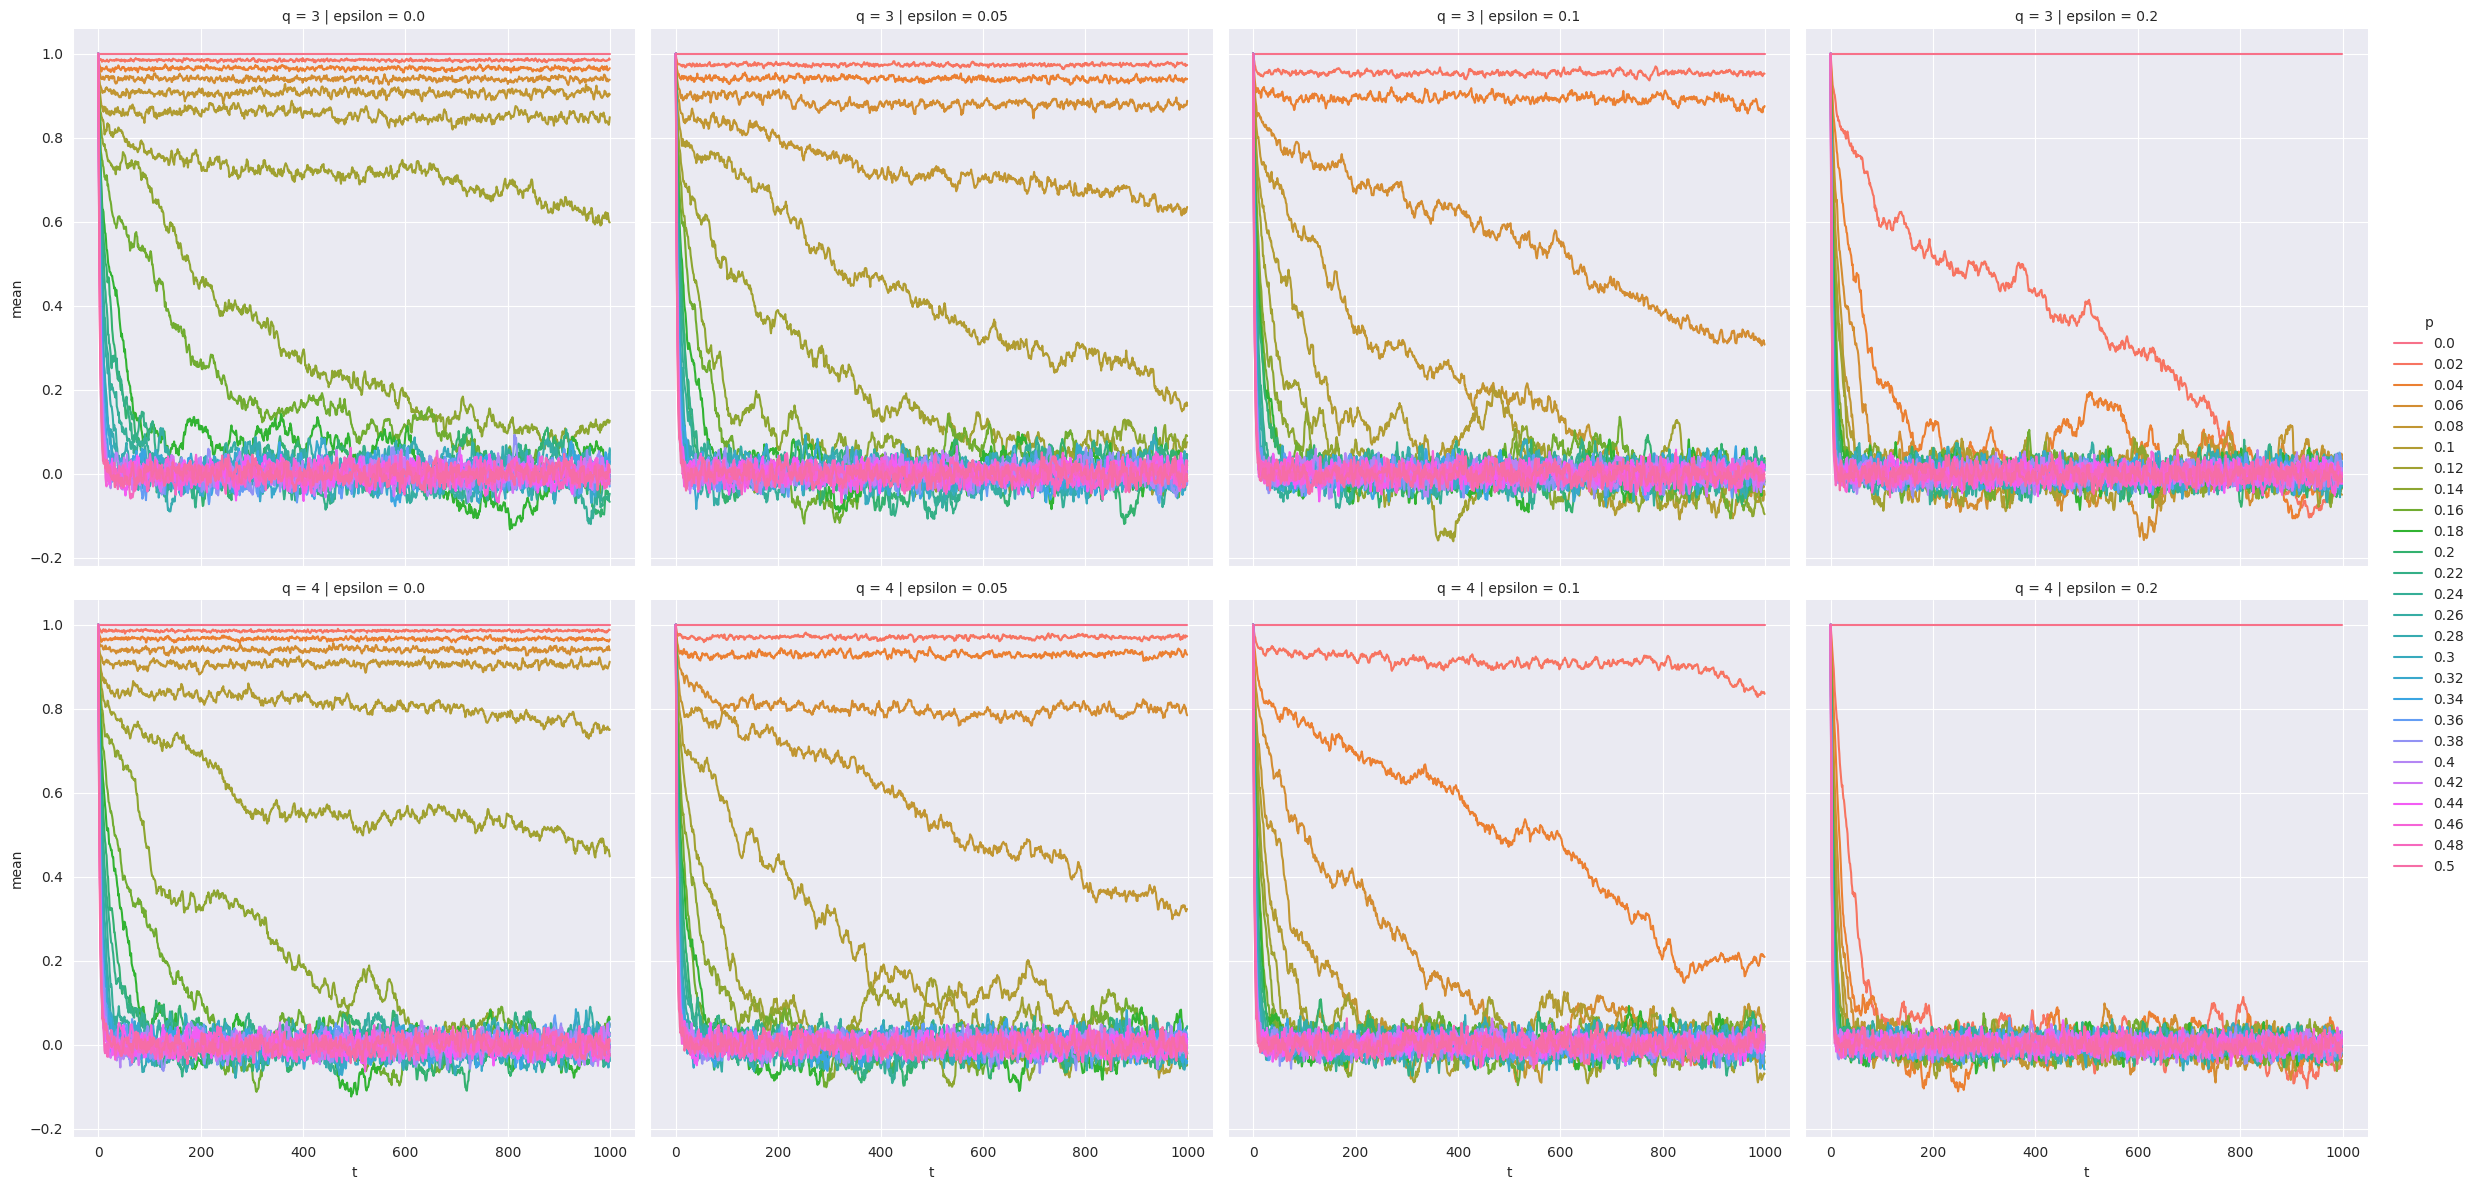

In [10]:
g = sns.FacetGrid(melt_df_BA_100_4, col="epsilon", row="q", hue="p",  height=6)
g.map(sns.lineplot, "t", "mean", errorbar = None)
g.add_legend()

# WS(100, 4, 0.01)

In [7]:
WS_100_4_001 = graph = Graph().Watts_Strogatz_model(100, 4, 0.01)
qs = [3, 4]
MC_steps = 1000
epsilon = 0.5
graph_type = "WS_100_4_001"
ps = np.arange(0, 0.52, 0.02).round(3)
epsilons = [0, 0.05, 0.1, 0.2]
n = 100

In [8]:
for q in qs:
    simulacion(WS_100_4_001, graph_type, epsilons, ps, n, q, MC_steps, True)

100%|██████████| 2600/2600 [04:18<00:00, 11.27it/s]


In [9]:
df_WS_100_4_001 = create_df_from_save_dir(graph_type, epsilons, ps, n, qs, MC_steps)
melt_df_WS_100_4_001 = df_WS_100_4_001.melt(["p", "q", "epsilon"], var_name="t", value_name="mean")

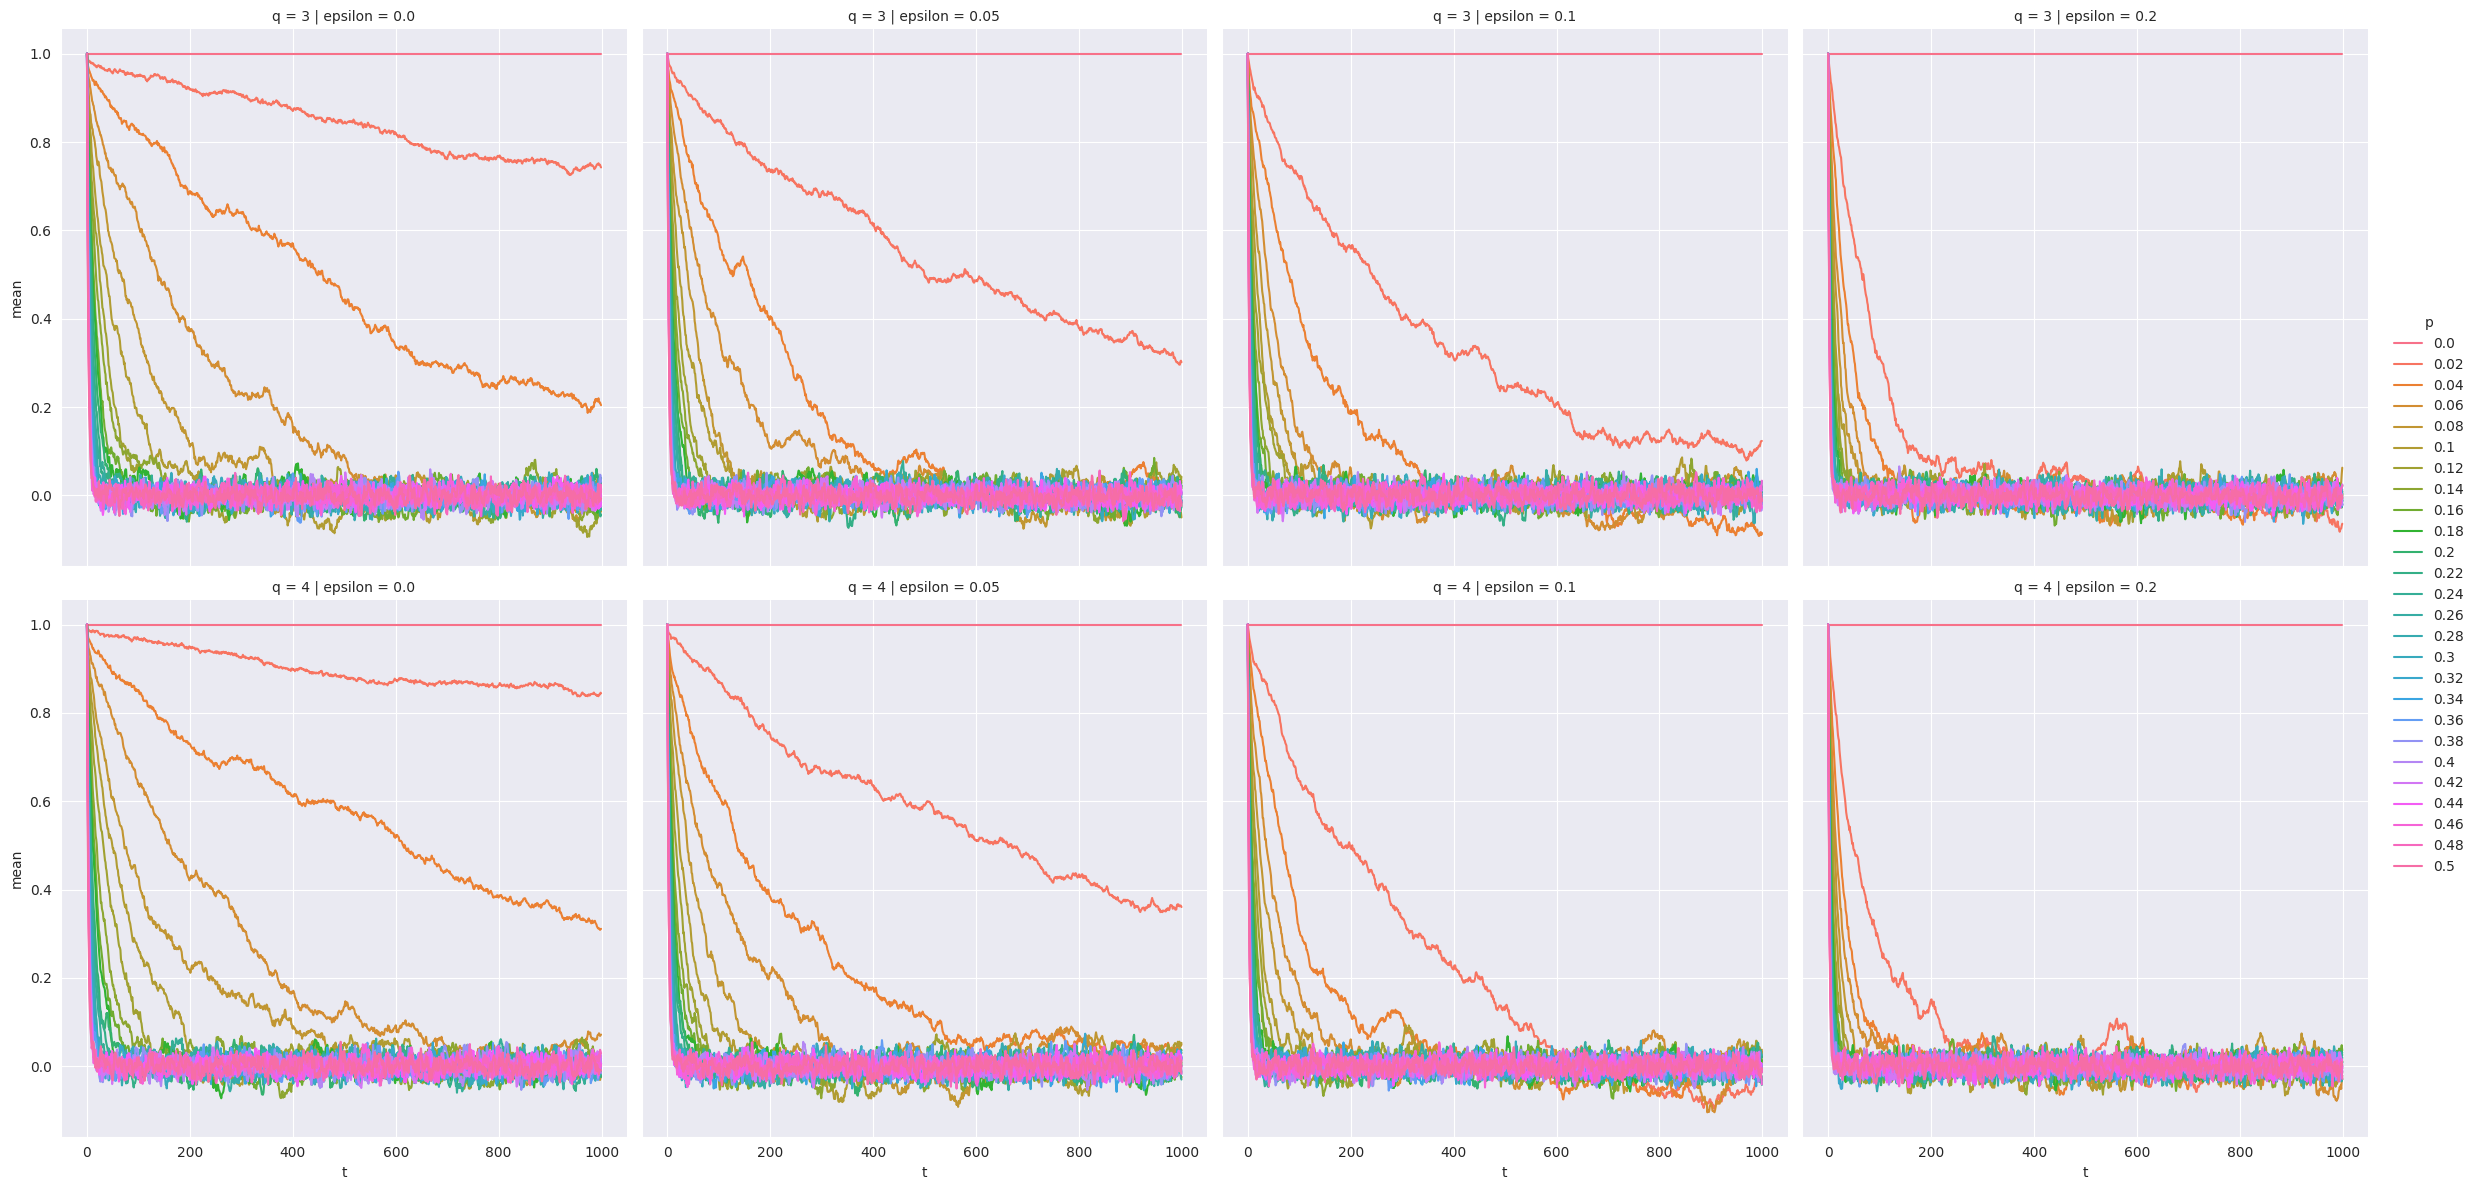

In [10]:
g = sns.FacetGrid(melt_df_WS_100_4_001, col="epsilon", row="q", hue="p",  height=6)
g.map(sns.lineplot, "t", "mean", errorbar = None)
g.add_legend()

# WS(100, 4, 0.2)

In [7]:
WS_100_4_02 = graph = Graph().Watts_Strogatz_model(100, 4, 0.2)

qs = [3, 4]
MC_steps = 1000
epsilon = 0.5
graph_type = "WS_100_4_02"
ps = np.arange(0, 0.52, 0.02).round(3)
epsilons = [0, 0.05, 0.1, 0.2]
n = 100

In [8]:
for q in qs:
    simulacion(WS_100_4_02, graph_type, epsilons, ps, n, q, MC_steps, True)

  2%|▏         | 44/2600 [00:07<07:14,  5.89it/s]

In [ ]:
df_WS_100_4_02 = create_df_from_save_dir(graph_type, epsilons, ps, n, qs, MC_steps)
melt_df_WS_100_4_02 = df_WS_100_4_02.melt(["p", "q", "epsilon"], var_name="t", value_name="mean")

In [ ]:
g = sns.FacetGrid(melt_df_WS_100_4_02, col="epsilon", row="q", hue="p",  height=6)
g.map(sns.lineplot, "t", "mean", errorbar = None)
g.add_legend()